# Credit card fraud detector

In this solution we will build the core of a credit card fraud detection system using SageMaker. We will start by training an anomaly detection algorithm, then proceed to train two XGBoost models for supervised training. To deal with the highly unbalanced data common in fraud detection, our first model will use re-weighting of the data, and the second will use re-sampling, using the popular SMOTE technique for oversampling the rare fraud data.

Our solution includes an example of making calls to a REST API to simulate a real deployment, using AWS Lambda to trigger both the anomaly detection and XGBoost model.

## Investigate and process the data

Let's start by reading in the credit card fraud data set.

In [1]:
import numpy as np 
import pandas as pd

data = pd.read_csv('creditcard.csv', delimiter=',')

Let's take a peek at our data (we only show a subset of the columns in the table):

In [2]:
print(data.columns)
data[['Time', 'V1', 'V2', 'V27', 'V28', 'Amount', 'Class']].describe()

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


,Time,V1,V2,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,3.161220e+01,3.384781e+01,25691.160000,1.000000


The dataset contains
only numerical features, because the original features have been transformed for confidentiality using PCA. As a result,
the dataset contains 28 PCA components, V1-V28, and two features that haven't been transformed, _Amount_ and _Time_.
_Amount_ refers to the transaction amount, and _Time_ is the seconds elapsed between any transaction in the data
and the first transaction.

The class column corresponds to whether or not a transaction is fraudulent. We see that the majority of data is non-fraudulent with only $492$ ($0.173\%$) of the data corresponding to fraudulent examples, out of the total of 284,807 examples in the data.

In [3]:
nonfrauds, frauds = data.groupby('Class').size()
print('Number of frauds: ', frauds)
print('Number of non-frauds: ', nonfrauds)
print('Percentage of fradulent data:', 100.*frauds/(frauds + nonfrauds))

Number of frauds:  492
Number of non-frauds:  284315
Percentage of fradulent data: 0.1727485630620034


We already know that the columns $V_i$ have been normalized to have $0$ mean and unit standard deviation as the result of a PCA.

In [4]:
feature_columns = data.columns[:-1]
label_column = data.columns[-1]

features = data[feature_columns].values.astype('float32')
labels = (data[label_column].values).astype('float32')

Next, we will prepare our data for loading and training.

## Training

We will split our dataset into a train and test to evaluate the performance of our models. It's important to do so _before_ any techniques meant to alleviate the class imbalance are used. This ensures that we don't leak information from the test set into the train set.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.1, random_state=42)

> Note: If you are bringing your own data to this solution and they include categorical data, that have strings as values, you'd need to one-hot encode these values first using for example sklearn's [OneHotEncoder](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features), as XGBoost only supports numerical data.

## Unsupervised Learning

In a fraud detection scenario, commonly we will have very few labeled examples, and it's possible that labeling fraud takes a very long time. We would like then to extract information from the unlabeled data we have at hand as well. _Anomaly detection_ is a form of unsupervised learning where we try to identify anomalous examples based solely on their feature characteristics. Random Cut Forest is a state-of-the-art anomaly detection algorithm that is both accurate and scalable. We will train such a model on our training data and evaluate its performance on our test set.

In [6]:
import boto3
import os
import sagemaker
from sagemaker import get_execution_role
from package import config

session = sagemaker.Session()
bucket = config.MODEL_DATA_S3_BUCKET
prefix = 'fraud-classifier'

In [7]:
from sagemaker import RandomCutForest

# specify general training job information
rcf = RandomCutForest(role=get_execution_role(),
                      train_instance_count=1,
                      train_instance_type='ml.c4.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=512,
                      num_trees=50)

Now we are ready to fit the model. The below cell should take around 5 minutes to complete.

In [8]:
rcf.fit(rcf.record_set(X_train))

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-09-21 15:40:05 Starting - Starting the training job...
2020-09-21 15:40:07 Starting - Launching requested ML instances............
2020-09-21 15:42:06 Starting - Preparing the instances for training...
2020-09-21 15:42:52 Downloading - Downloading input data...
2020-09-21 15:43:10 Training - Downloading the training image...
2020-09-21 15:44:05 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python2.7/site-packages/scipy/_lib/_numpy_compat.py:10: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing.nosetester import import_nose
/opt/amazon/lib/python2.7/site-packages/scipy/stats/morestats.py:12: DeprecationWarning: Importing from numpy.testing.decorators is deprecated, import from numpy.testing instead.
  from numpy.testing.decorators import setastest
[09/21/2020 15:44:11 

### Host Random Cut Forest

Once we have a trained model we can deploy it and get some predictions for our test set. SageMaker will spin up an instance for us and deploy the model, the whole process should take around 10 minutes, you will see progress being made with each `-` and an exclamation point when the process is finished.

In [9]:
rcf_predictor = rcf.deploy(
    model_name="{}-rcf".format(config.STACK_NAME),
    endpoint_name="{}-rcf".format(config.STACK_NAME),
    initial_instance_count=1,
    instance_type='ml.c4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


------------------!

In [10]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_predictor.content_type = 'text/csv'
rcf_predictor.serializer = csv_serializer
rcf_predictor.accept = 'application/json'
rcf_predictor.deserializer = json_deserializer

### Test Random Cut Forest

With the model deployed, let's see how it performs in terms of separating fraudulent from legitimate transactions.

In [11]:
def predict_rcf(current_predictor, data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = []
    for array in split_array:
        array_preds = [s['score'] for s in current_predictor.predict(array)['scores']]
        predictions.append(array_preds)

    return np.concatenate([np.array(batch) for batch in predictions])

In [12]:
positives = X_test[y_test == 1]
positives_scores = predict_rcf(rcf_predictor, positives)

negatives = X_test[y_test == 0]
negatives_scores = predict_rcf(rcf_predictor, negatives)

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

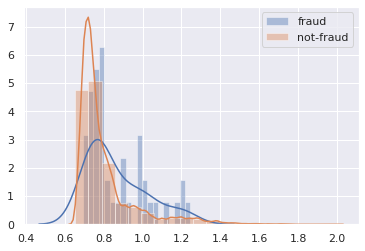

In [14]:
sns.distplot(positives_scores, label='fraud', bins=20)
sns.distplot(negatives_scores, label='not-fraud', bins=20)
plt.legend()

The unsupervised model already can achieve some separation between the classes, with higher anomaly scores being correlated to fraud.

## Supervised Learning

Once we have gathered an adequate amount of labeled training data, we can use a supervised learning algorithm that discovers relationships between the features and the dependent class.

We will use Gradient Boosted Trees as our model, as they have a proven track record, are highly scalable and can deal with missing data, reducing the need to pre-process datasets.

### Prepare Data and Upload to S3

First we copy the data to an in-memory buffer.

In [15]:
import io
import sklearn
from sklearn.datasets import dump_svmlight_file   

buf = io.BytesIO()

sklearn.datasets.dump_svmlight_file(X_train, y_train, buf)
buf.seek(0);

Now we upload the data to S3 using boto3.

In [16]:
key = 'fraud-dataset'
subdir = 'base'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', subdir, key)).upload_fileobj(buf)

s3_train_data = 's3://{}/{}/train/{}/{}'.format(bucket, prefix, subdir, key)
print('Uploaded training data location: {}'.format(s3_train_data))

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Uploaded training data location: s3://sagemaker-fraud-machine-learning-modeldatabucket-14xyy5p17ag8g/fraud-classifier/train/base/fraud-dataset
Training artifacts will be uploaded to: s3://sagemaker-fraud-machine-learning-modeldatabucket-14xyy5p17ag8g/fraud-classifier/output


We can now train using SageMaker's built-in XGBoost algorithm. To specify the XGBoost algorithm, we use a utility function to obtain its URI. A complete list of built-in algorithms is found here: https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html

In [17]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'xgboost', repo_version='0.90-2')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
	get_image_uri(region, 'xgboost', '1.0-1').


SageMaker abstracts training via Estimators. We can pass the classifier and parameters along with hyperparameters to the estimator, and fit the estimator to the data in S3. An important parameter here is `scale_pos_weight` which scales the weights of the positive vs. negative class examples. This is crucial to do in an imbalanced dataset like the one we are using here, otherwise the majority class would dominate the learning.

In [18]:
from math import sqrt
from sagemaker import get_execution_role

# Because the data set is so highly skewed, we set the scale position weight conservatively,
# as sqrt(num_nonfraud/num_fraud).
# Other recommendations for the scale_pos_weight are setting it to (num_nonfraud/num_fraud).
scale_pos_weight = sqrt(np.count_nonzero(y_train==0)/np.count_nonzero(y_train))
hyperparams = {
    "max_depth":5,
    "subsample":0.8,
    "num_round":100,
    "eta":0.2,
    "gamma":4,
    "min_child_weight":6,
    "silent":0,
    "objective":'binary:logistic',
    "eval_metric":'auc',
    "scale_pos_weight": scale_pos_weight
}

Let us explain the hyper-parameters used above. The one that's very relevant for learning from skewed data is `scale_pos_weight`. This is a ratio that weighs the examples of the positive class (fraud) against the negative class (legitimate). Commonly this is set to `(num_nonfraud/num_fraud)`, but our data is exteremely skewed so we will set it to `sqrt(num_nonfraud/num_fraud)`.  For the data in this example, this would be `sqrt(284,807/492)` which would give our fraud examples a weight of ~24.

The rest of the hyper-parameters are as follows:

* `max_depth`: This is the maximum depth of the trees that will be built for our ensemble. A max depth of 5 will give us trees with up to 32 leaves. Note that tree size grows exponentially when increasing this parameter (`num_leaves=2^max_depth`), so a max depth of 10 would give us trees with 1024 leaves, which are likely to overfit.
* `subsample`: The subsample ratio that we use to select a subset of the complete data to train each tree in the ensemble. With a value of 0.8, each tree is trained on a random sample containing 80% of the complete data. This is used to prevent overfitting.
* `num_round`: This is the size of the ensemble. We will for 100 "rounds", each training round adding a new tree to the ensemble.
* `eta`: This is the step size shrinkage applied at each update. This value will shrink the weights of new features to prevent overfitting.
* `gamma`: This is the minimum loss reduction to reach before splitting a leaf. Splitting a leaf can sometimes have a small benefit, and splitting such leaves can lead to overfitting. By setting `gamma` to values larger than zero, we ensure that there should be at least some non-negligible amount of accuracy gain before splitting a leaf.
* `min_child_weight`: This parameter has a similar effect to gamma, setting it to higher values means we'll wait until enough gain will be possible before splitting a leaf.
* `objective`: We are doing binary classification, so we use a logistic loss objective.
* `eval_metric`: Having a good evaluation metric is crucial when dealing with imbalanced data (see discussion below). We use AUC here.

In [19]:
clf = sagemaker.estimator.Estimator(container,
                                    get_execution_role(),
                                    hyperparameters=hyperparams,
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path=output_location,
                                    sagemaker_session=session)

We can now fit our supervised training model, the call to fit below should take around 5 minutes to complete.

In [20]:
clf.fit({'train': s3_train_data})

2020-09-21 15:55:27 Starting - Starting the training job...
2020-09-21 15:55:29 Starting - Launching requested ML instances............
2020-09-21 15:57:30 Starting - Preparing the instances for training...
2020-09-21 15:58:19 Downloading - Downloading input data......
2020-09-21 15:59:23 Training - Training image download completed. Training in progress..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
[15:59:25] 256326x30 matrix with 7688153 entries loaded from /opt/ml/input/data/train
INFO:root:Single node training.
INFO:root:Train matrix has 256326 rows
[0]#

### Host Classifier

Now we deploy the estimator to and endpoint. As before progress will be indicated by `-`, and the deployment should be done after 10 minutes.

In [21]:
from sagemaker.predictor import csv_serializer

predictor = clf.deploy(initial_instance_count=1,
                       model_name="{}-xgb".format(config.STACK_NAME),
                       endpoint_name="{}-xgb".format(config.STACK_NAME),
                       instance_type='ml.m4.xlarge', 
                       serializer=csv_serializer,
                       deserializer=None,
                       content_type='text/csv')

---------------!

## Evaluation

Once we have trained the model we can use it to make predictions for the test set.

In [22]:
# Because we have a large test set, we call predict on smaller batches
def predict(current_predictor, data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, current_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

In [23]:
raw_preds = predict(predictor, X_test)

We will use a few measures from the scikit-learn package to evaluate the performance of our model. When dealing with an imbalanced dataset, we need to choose metrics that take into account the frequency of each class in the data.

Two such metrics are the [balanced accuracy score](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score), and [Cohen's Kappa](https://scikit-learn.org/stable/modules/model_evaluation.html#cohen-s-kappa).

In [24]:
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score

# scikit-learn expects 0/1 predictions, so we threshold our raw predictions
y_preds = np.where(raw_preds > 0.5, 1, 0)
print("Balanced accuracy = {}".format(balanced_accuracy_score(y_test, y_preds)))
print("Cohen's Kappa = {}".format(cohen_kappa_score(y_test, y_preds)))

Balanced accuracy = 0.9021211611532022
Cohen's Kappa = 0.860255159493083


We can already see that our model performs very well in terms of both metrics, Cohen's Kappa scores above 0.8 are generally very favorable.

Apart from single-value metrics, it's also useful to look at metrics that indicate performance per class. A confusion matrix, and per-class precision, recall and f1-score can also provide more information about the model's performance.

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_predicted):

    cm  = confusion_matrix(y_true, y_predicted)
    # Get the per-class normalized value for each cell
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # We color each cell according to its normalized value, annotate with exact counts.
    ax = sns.heatmap(cm_norm, annot=cm, fmt="d")
    ax.set(xticklabels=["non-fraud", "fraud"], yticklabels=["non-fraud", "fraud"])
    ax.set_ylim([0,2])
    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()

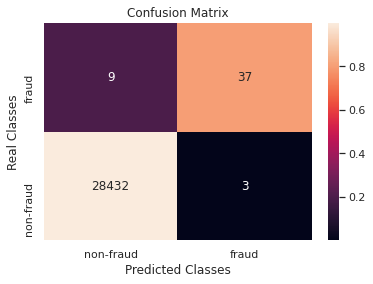

In [26]:
plot_confusion_matrix(y_test, y_preds)

In [27]:
from sklearn.metrics import classification_report

print(classification_report(
    y_test, y_preds, target_names=['non-fraud', 'fraud']))

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     28435
       fraud       0.93      0.80      0.86        46

    accuracy                           1.00     28481
   macro avg       0.96      0.90      0.93     28481
weighted avg       1.00      1.00      1.00     28481



### Keep sending test traffic to the endpoint via lambda

We can now show how we could use both of these models in a production system, using HTTP requests to an AWS Lambda function that invokes both the unsupervised and the supervised SageMaker endpoints.

We create a background thread that will constantly create HTTP requests to invoke the Lambda, using our test data as input. See the included `generate_endpoint_traffic.py` file to see how that is done.
The output will be logged to an S3 bucket through Kinesis, and you can also observe it in the Lambda function's CloudWatch logs.

In [28]:
from threading import Thread
from package.generate_endpoint_traffic import generate_traffic

thread = Thread(target = generate_traffic, args=[np.copy(X_test)])
thread.start()


### SMOTE

Now that we have a baseline model using XGBoost, we can try to see if sampling techniques that are designed specifically for imbalanced problems can improve the performance of the model.

For that purpose we will be using the [imbalanced-learn](https://imbalanced-learn.readthedocs.io/en/stable/index.html) package that works well with scikit-learn. We have pre-installed the package for this kernel, but if you need it for a different Jupyter kernel you can install it by running `pip install --upgrade imbalanced-learn` within the conda environment you need.

We will be using [Sythetic Minority Over-sampling](https://arxiv.org/abs/1106.1813) (SMOTE), which oversamples the minority class by interpolating new data points between existing ones.

In [29]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

We can see that SMOTE has now balanced the two classes:

In [30]:
from collections import Counter
print(sorted(Counter(y_smote).items()))

[(0.0, 255880), (1.0, 255880)]


We note that this is a case of extreme oversampling of the the minority class, we went from ~0.17% to 50%. An alternative would be to use a smaller resampling ratio, such as having one minority cl
ass sample for every `sqrt(non_fraud/fraud)` majority samples, or using more advanced resampling techniques. See the [comparison](https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/over-sampling/plot_comparison_over_sampling.html#sphx-glr-auto-examples-over-sampling-plot-comparison-over-sampling-py) provided by imbalanced-learn for more over-sampling options.

In our case we'll use the SMOTE dataset we just created and upload it to S3 for training.

In [31]:
smote_buf = io.BytesIO()

# Dump the SMOTE data into a buffer
sklearn.datasets.dump_svmlight_file(X_smote, y_smote, smote_buf)
smote_buf.seek(0);

# Upload from the buffer to S3
key = 'fraud-dataset-smote'
subdir = 'smote'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', subdir, key)).upload_fileobj(smote_buf)

s3_smote_train_data = 's3://{}/{}/train/{}/{}'.format(bucket, prefix, subdir, key)
print('Uploaded training data location: {}'.format(s3_smote_train_data))

smote_output_location = 's3://{}/{}/smote-output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(smote_output_location))

Uploaded training data location: s3://sagemaker-fraud-machine-learning-modeldatabucket-14xyy5p17ag8g/fraud-classifier/train/smote/fraud-dataset-smote
Training artifacts will be uploaded to: s3://sagemaker-fraud-machine-learning-modeldatabucket-14xyy5p17ag8g/fraud-classifier/smote-output


In [32]:
# No need to scale weights after SMOTE resampling, so we remove that parameter
hyperparams.pop("scale_pos_weight", None)
smote_xgb = sagemaker.estimator.Estimator(container,
                                        get_execution_role(),
                                        hyperparameters=hyperparams,
                                        train_instance_count=1, 
                                        train_instance_type='ml.m4.xlarge',
                                        output_path=smote_output_location,
                                        sagemaker_session=session)

We are now ready to fit the model, which should take around 5 minutes to complete.

In [33]:
smote_xgb.fit({'train': s3_smote_train_data})

2020-09-21 16:10:05 Starting - Starting the training job...
2020-09-21 16:10:08 Starting - Launching requested ML instances......
2020-09-21 16:11:23 Starting - Preparing the instances for training......
2020-09-21 16:12:24 Downloading - Downloading input data...
2020-09-21 16:13:00 Training - Downloading the training image...
2020-09-21 16:13:30 Training - Training image download completed. Training in progress..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
[16:13:33] 511760x30 matrix with 15349834 entries loaded from /opt/ml/input/data/train
INFO:root:Singl

After fitting the model we can check its performance to compare it against the base XGBoost model. The deployment will take around 10 minutes.

In [ ]:
smote_predictor = smote_xgb.deploy(initial_instance_count=1,
                       model_name="{}-xgb-smote".format(config.STACK_NAME),
                       endpoint_name="{}-xgb-smote".format(config.STACK_NAME),
                       instance_type='ml.m4.xlarge')

# Specify input and output formats.
smote_predictor.content_type = 'text/csv'
smote_predictor.serializer = csv_serializer
smote_predictor.deserializer = None

-----------

In [ ]:
smote_raw_preds = predict(smote_predictor, X_test)
smote_preds = np.where(smote_raw_preds > 0.5, 1, 0)

In [ ]:
print("Balanced accuracy = {}".format(balanced_accuracy_score(y_test, smote_preds)))
print("Cohen's Kappa = {}".format(cohen_kappa_score(y_test, smote_preds)))

In [ ]:
plot_confusion_matrix(y_test, smote_preds)

In [ ]:
print(classification_report(
    y_test, smote_preds, target_names=['non-fraud', 'fraud']))

Due to the randomness of XGBoost your results may vary, but overall, you should see a large increase in non-fraud cases being classified as fraud (false positives). The reason this happens is because SMOTE has oversampled the fraud class so much that it's increased its overlap in feature space with the non-fraud cases.
Since Cohen's Kappa gives more weight to false positives than balanced accuracy does, the metric drops significantly, as does the precision and F1 score for fraud cases. However, we can bring a balance between the metrics again by adjusting our classification threshold.

So far we've been using 0.5 as the threshold between labeling a point as fraud or not. We can try different thresholds to see if they affect the result of the classification. To evaluate we'll use the balanced accuracy and Cohen's Kappa metrics.

In [ ]:
for thres in np.linspace(0.1, 0.9, num=9):
    smote_thres_preds = np.where(smote_raw_preds > thres, 1, 0)
    print("Threshold: {:.1f}".format(thres))
    print("Balanced accuracy = {:.3f}".format(balanced_accuracy_score(y_test, smote_thres_preds)))
    print("Cohen's Kappa = {:.3f}\n".format(cohen_kappa_score(y_test, smote_thres_preds)))

We see that Cohen's Kappa keeps increasing along with the threshold, without a significant loss in balanced accuracy. This adds a useful knob to our model: We can keep a low threshold if we care more about not missing any fraudulent cases, or we can increase the threshold to try to minimize the number of false positives.

## Clean up

We will leave the unsupervised and base XGBoost endpoints running at the end of this notebook so we can handle incoming event streams. However, don't forget to delete the prediction endpoints when you're done. You can do that at the Amazon SageMaker console in the Endpoints page. Or you can run `predictor_name.delete_endpoint()`

In [ ]:
# Uncomment to clean up endpoints
# rcf_predictor.delete_model()
# rcf_predictor.delete_endpoint()
# predictor.delete_endpoint()
# predictor.delete_model()
smote_predictor.delete_model()
smote_predictor.delete_endpoint()


## Data Acknowledgements

The dataset used to demonstrated the fraud detection solution has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the [DefeatFraud](https://mlg.ulb.ac.be/wordpress/portfolio_page/defeatfraud-assessment-and-validation-of-deep-feature-engineering-and-learning-solutions-for-fraud-detection/) project
We cite the following works:
* Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015
* Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. Learned lessons in credit card fraud detection from a practitioner perspective, Expert systems with applications,41,10,4915-4928,2014, Pergamon
* Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. Credit card fraud detection: a realistic modeling and a novel learning strategy, IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE
* Dal Pozzolo, Andrea Adaptive Machine learning for credit card fraud detection ULB MLG PhD thesis (supervised by G. Bontempi)
* Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-Aël; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. Scarff: a scalable framework for streaming credit card fraud detection with Spark, Information fusion,41, 182-194,2018,Elsevier
* Carcillo, Fabrizio; Le Borgne, Yann-Aël; Caelen, Olivier; Bontempi, Gianluca. Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization, International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing